In [1]:
from Project1_a_b import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
### random seed
np.random.seed(123)

# Runge function
def runge(x): return 1 / (1 + 25*x**2)

In [3]:
"""
Set parameters
"""

num_pts = 1000
# uniform distributed random data points
x_pts = np.random.uniform(-1, 1, num_pts)
max_polynomial_deg = 15
degs = np.arange(1, max_polynomial_deg + 1)
lam = 0.5                                           # hyper paramter for Ridge

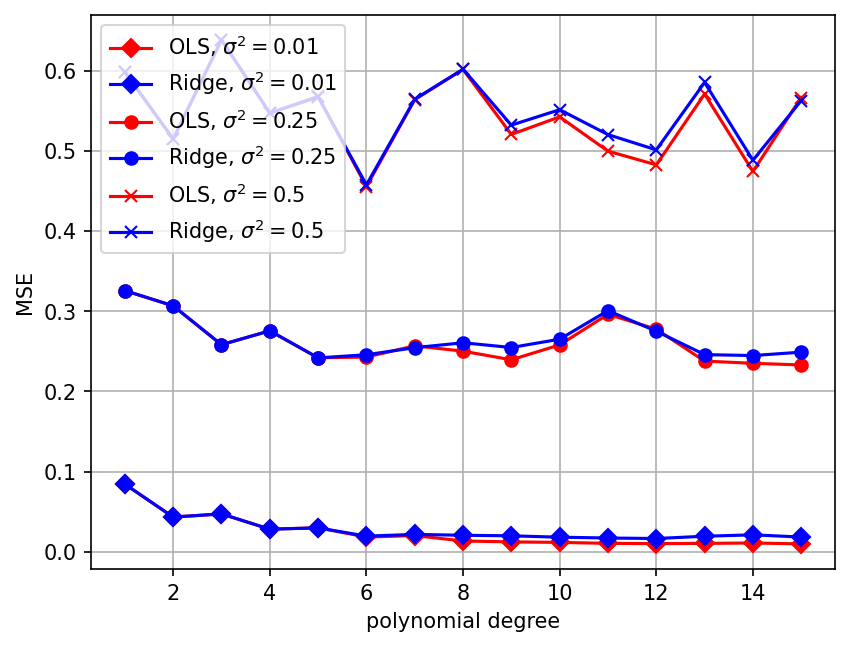

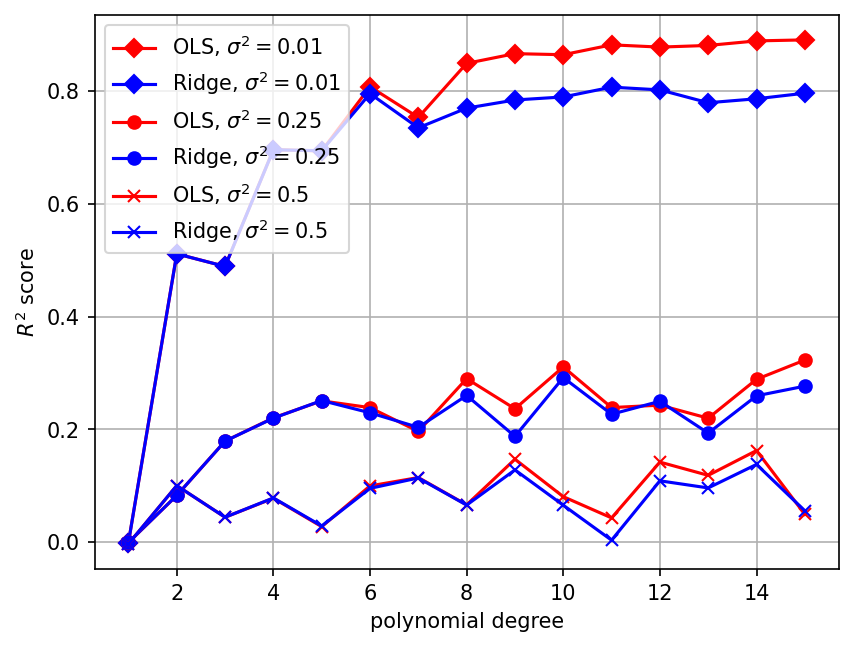

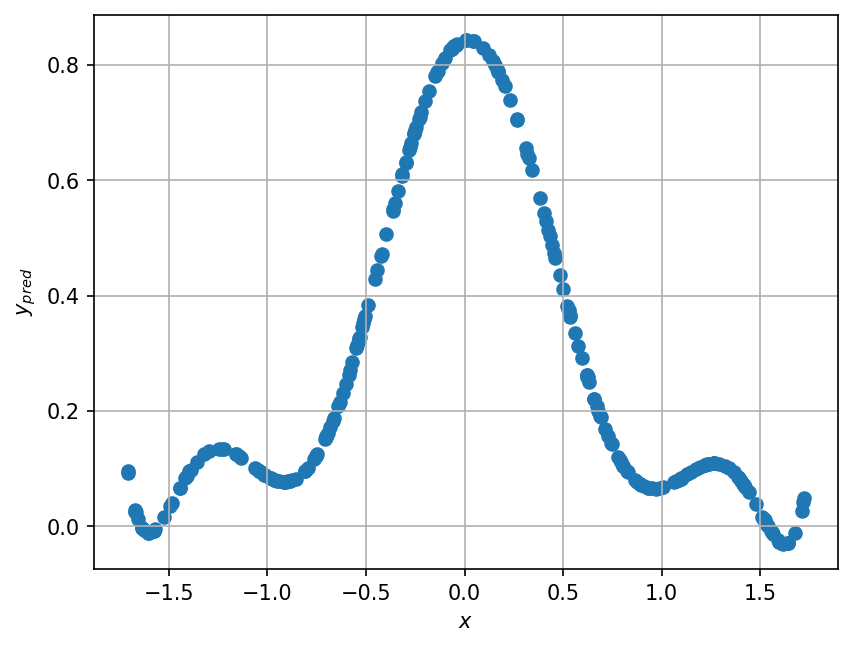

In [4]:
"""
Numerical Experiment 1
===============================================================================
compute MSE and R^2 score for OLS and Ridge regression using polynomials of 
degree up to 15
"""

mses_ols = []                                       # collect data
mses_ridge = []
r2_ols = []
r2_ridge = []
betas_ols = []
variances = np.array([0.01, 0.25, 0.5])

for v in variances:
    # generate noisy data
    y_pts_ = runge(x_pts) + np.random.normal(0, np.sqrt(v), num_pts)
    mse_ols_ = []                                   # collect mses for fixed variance
    r2_ols_ = []
    mse_ridge_ = []
    r2_ridge_ = []
    beta_ols_ = []                                  # store coeffs for later use
    for deg in degs:
        X_train, X_test, y_train, y_test, y_mean = get_scaled_data(x_pts, 
                                                                   y_pts_, deg)
        # compute approximation using OLS
        beta_ols = ols(X_train, y_train)
        beta_ols_.append(beta_ols)
        y_predict = X_test @ beta_ols
        mse_ols_.append(mse(y_predict, y_test))
        r2_ols_.append(r2(y_predict, y_test))
        # compute approximation using Ridge regression
        beta_ridge = ridge(X_train, y_train, lam)
        y_predict_ridge = X_test @ beta_ridge
        mse_ridge_.append(mse(y_predict_ridge, y_test))
        r2_ridge_.append(r2(y_predict_ridge, y_test))
        # only for testing later
        if deg == 8 and v == 0.01:
            y_ = y_predict + y_mean
            x_ = X_test[:,0]
    mses_ols.append(mse_ols_)
    r2_ols.append(r2_ols_)
    mses_ridge.append(mse_ridge_)
    r2_ridge.append(r2_ridge_)
    betas_ols.append(beta_ols_)

""" Plot the data """

markers = ['D', 'o', 'x']
# figure for MSEs
plot_results(degs, np.array(mses_ols), np.array(mses_ridge),
             variances, markers)
# figures for R^2 scores
plot_results(degs, np.array(r2_ols), np.array(r2_ridge), 
             variances, markers, quantity='R2')


""" Plot the approximation for one example """

# not in the report - only for checking the result
# deg = 8, sigma^2 = 0.01

plt.figure(dpi=150)
plt.scatter(x_, y_)
plt.grid()
plt.xlabel(r'$x$')
plt.ylabel(r'$y_{pred}$')
plt.show()

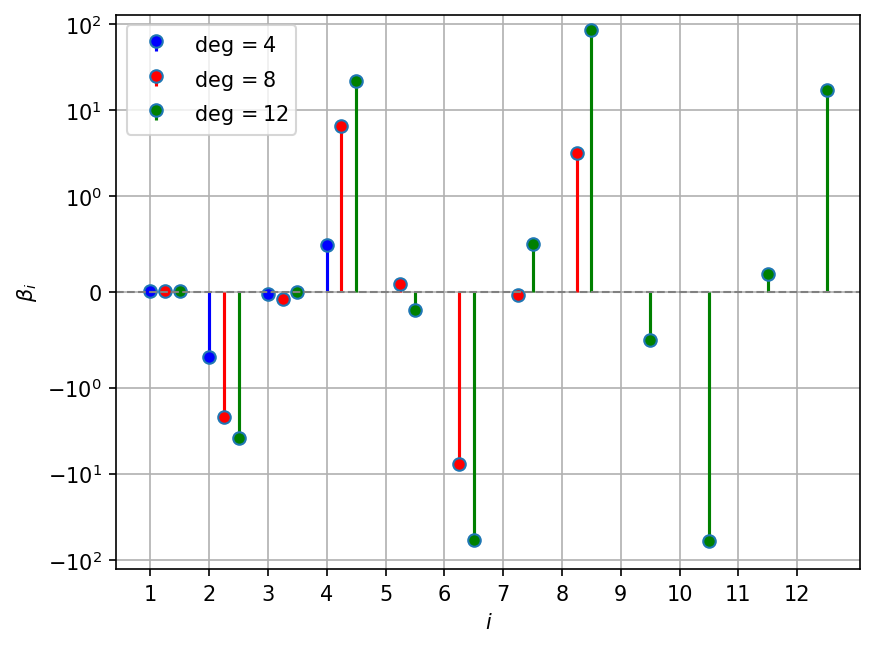

In [5]:
""" Plot coefficients - use sigma^2 = 0.01 """

betas = betas_ols[0]

plt.figure(dpi=150)
colors_ = ['blue', 'red', 'green']
for (i, beta) in enumerate(betas[3::4]):
    markerline, stemlines, baseline = plt.stem(
        np.arange(1, len(beta) + 1) + i/4, np.array(beta), linefmt=colors_[i], 
        bottom=0, label=r'$\deg = {}$'.format(4*(i+1)))
    markerline.set_markerfacecolor(colors_[i])
    # hide baseline in the for loop and create one common base line later
    baseline.set_visible(False)

# maximal coefficient - used for y-limit
m = np.max(np.array([np.max(np.abs(i)) for i in betas[3::4]]))

plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.grid()
plt.xlabel(r'$i$')
plt.xticks(np.arange(1, 13))
plt.ylabel(r'$\beta_i$')
plt.yscale('symlog', linthresh=1)
plt.ylim(-1.5*m, 1.5*m)
plt.legend()
plt.show()

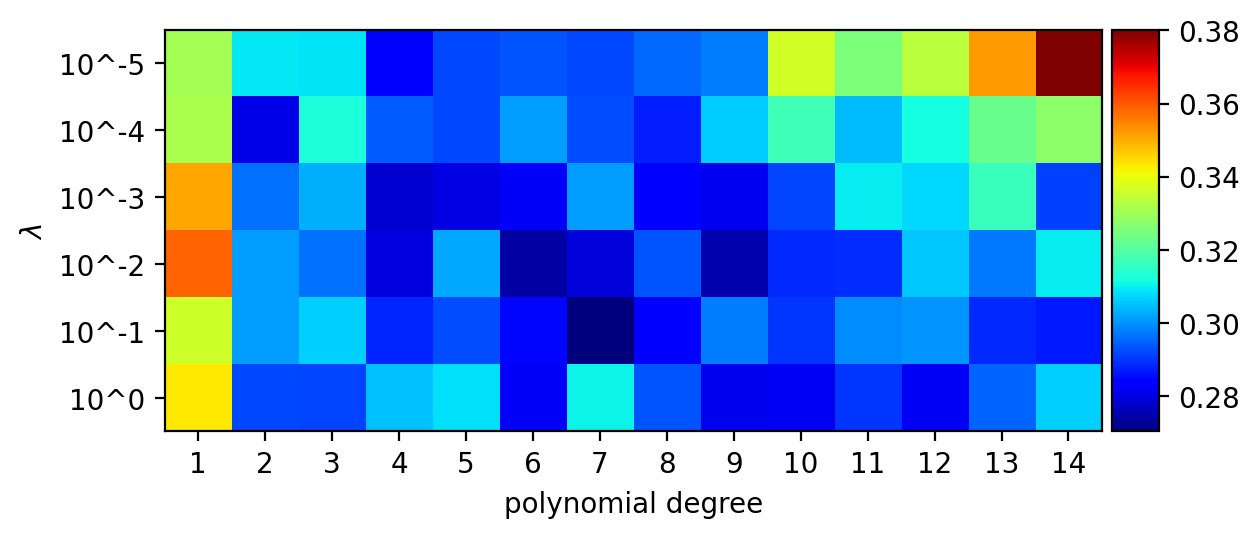

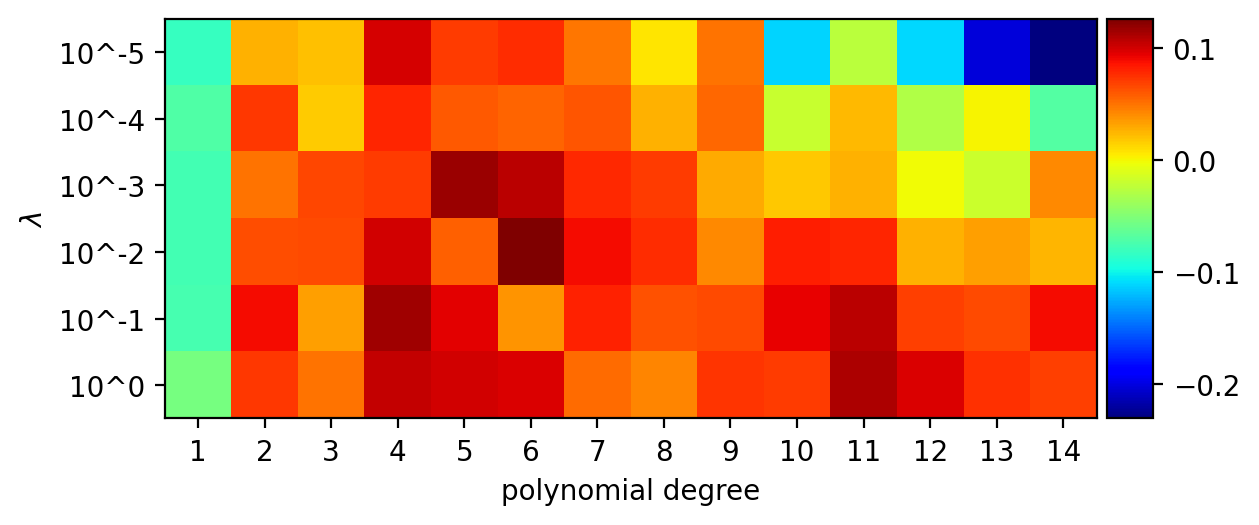

In [6]:
""" Test of Ridge regression - use sigma^2 = 0.25 """

mses = []
r2_scores = []
lambdas = np.logspace(-5, 0, 6)
num_pts = 100
x_pts = np.random.uniform(-1, 1, num_pts)
degs = np.arange(1, 15)

for param in lambdas:
    lst_mse = []
    lst_r2 = []
    for deg in degs:
        mses_ = []
        r2_ = []
        # we do 100 experiments for every combination of degree and lambda
        for i in range(100):
            # noisy data, normal distributed with mean 0 and standard 
            # deviation 0.5
            y_pts = runge(x_pts) + np.random.normal(0, 0.5, num_pts)
            X_train, X_test, y_train, y_test, _ = get_scaled_data(x_pts, y_pts, 
                                                                deg)
            beta = ridge(X_train, y_train, param)
            y_predict = X_test @ beta
            mses_.append(mse(y_predict, y_test))
            r2_.append(r2(y_predict, y_test))
        # compute mean of the mses and r^2 scores
        lst_mse.append(np.mean(np.array(mses_)))
        lst_r2.append(np.mean(np.array(r2_)))
    mses.append(lst_mse)
    r2_scores.append(lst_r2)
    
""" Plot the MSE and R^2 score for Ridge regression using different hyper
parameters """
    
heat_map_ridge(lambdas, degs, mses)
heat_map_ridge(lambdas, degs, r2_scores, quantity='R2')

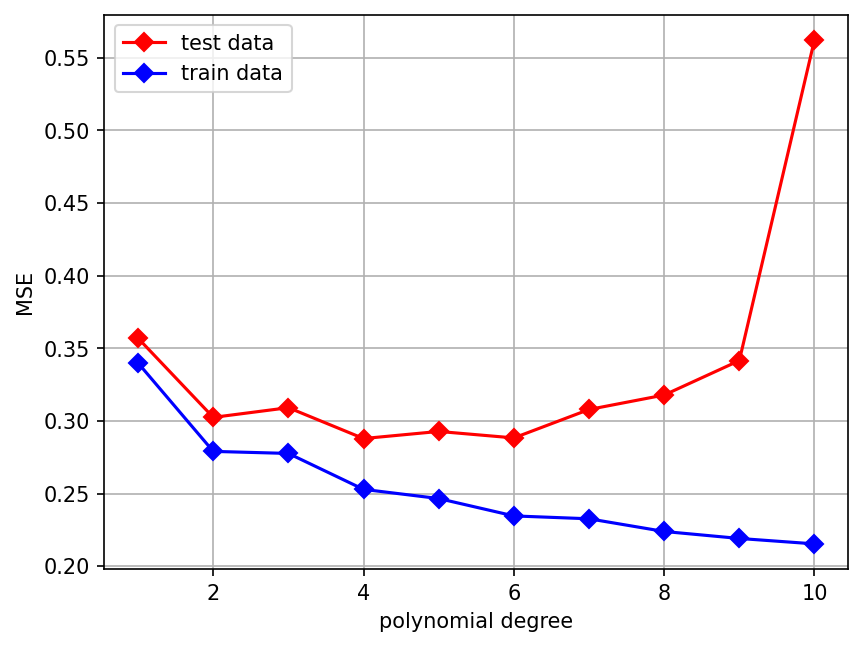

In [7]:
"""
Numerical Experiment 3
===============================================================================
train and test error - sigma^2 = 0.25
"""

### use different data - more noise for more interesting plot
num_pts = 100
x_pts = np.random.uniform(-1, 1, num_pts)

mse_test = []
mse_train = []
degs = np.arange(1, 11)
j = 0

for deg in degs:
    mse_test_ = []
    mse_train_ = []
    """
    Sample 1000 data sets for every polynomial degree and compute the MSE on
    the training and test data.
    Finally take the average of the MSEs.
    """
    for i in range(1000):
        # create new random values for y and to this end, always take a new seed
        np.random.seed(j)
        j += 1
        y_pts = runge(x_pts) + np.random.normal(0, 0.5, num_pts)
        # create feature matrix
        X = feature_matrix(x_pts, deg)
        # split in training and test data and scale it
        X_train, X_test, y_train, y_test, _ = get_scaled_data(x_pts, y_pts, deg)
        theta = ols(X_train, y_train)
        mse_test_.append(mse(X_test @ theta, y_test))
        mse_train_.append(mse(X_train @ theta, y_train))
    mse_test.append(np.mean(mse_test_))
    mse_train.append(np.mean(mse_train_))
    
plt.figure(dpi=150)    
plt.plot(degs, mse_test, '-D', color='red', label='test data')
plt.plot(degs, mse_train, '-D', color='blue', label='train data')
plt.grid()
plt.xlabel('polynomial degree')
plt.ylabel('MSE')
plt.legend()
plt.show()